In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb

project_name = "master-thesis"

interesting_run_names = ["baseline-phcd-paper", "architecture-1-phcd_paper", "architecture-2-phcd_paper", "architecture-7-phcd_paper" ] # "architecture-3-phcd_paper", "architecture-7-phcd_paper"
architectures = ["Bazowa", "Architektura A", "Architektura B", "Architektura C" ]
plot_titles = ["Dokładność architektury bazowej", "Dokładność architektury A", "Dokładność architektury B", "Dokładność architektury C" ]
api = wandb.Api()

# get all runs for a project    
runs = api.runs(f"gratkadlafana/{project_name}")

run_ids = []
for name in interesting_run_names:
    # get run id
    run_id = [run.id for run in runs if run.name == name and run.state == "finished"][0]
    print(f"Run {name}, id: {run_id}")
    run_ids.append(run_id)

Run baseline-phcd-paper, id: 134rtw3p
Run architecture-1-phcd_paper, id: 3of9wiae
Run architecture-2-phcd_paper, id: 132ahyko
Run architecture-7-phcd_paper, id: td2d5thr


In [26]:
results_table = pd.DataFrame(columns=["run_name", "test acc", "number of parameters", "GFLOPs", "throughput [images / s]", "compressed disk size [bytes]"])
for run_id, run_name in zip(run_ids, interesting_run_names):
    # for each run get the metrics and save them to the results_table
    run = api.run(f"gratkadlafana/{project_name}/{run_id}")
    metrics = run.summary
    new_row = pd.DataFrame({
        "run_name": run_name,
        "test acc": metrics["test_accuracy"],
        "number of parameters": metrics["num_parameters"],
        "GFLOPs": metrics["model_flops"],
        "throughput [images / s]": metrics["throughput"],
        "compressed disk size [bytes]": metrics["compressed_disk_size"]
    },
    index=[0])
    results_table = pd.concat([results_table, new_row], ignore_index=True)

results_table["compressed disk size [Mb]"] = results_table["compressed disk size [bytes]"].map(lambda x : round(x / 1024 / 1024, 3)) 
results_table["FLOPs (milions)"] = results_table["GFLOPs"].map(lambda x: round(x * 1000, 3))
results_table["number of parameters (thousands)"] = results_table["number of parameters"].map(lambda x : round(x / 1000, 3))
results_table["throughput [thousands of images / s]"] = results_table["throughput [images / s]"].map(lambda x : round(x / 1000, 3))
results_table["label"] = results_table["run_name"].map(lambda x : architectures[interesting_run_names.index(x)])

results_table = results_table[["run_name", "label", "test acc", "number of parameters (thousands)", "FLOPs (milions)", "compressed disk size [Mb]", "throughput [thousands of images / s]"]]
display(results_table)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


,run_name,label,test acc,number of parameters (thousands),FLOPs (milions),compressed disk size [Mb],throughput [thousands of images / s]
0,baseline-phcd-paper,Bazowa,0.856203,497.721,14.308,1.787,25.137
1,architecture-1-phcd_paper,Architektura A,0.972298,13831.385,17.223,49.536,27.396
2,architecture-2-phcd_paper,Architektura B,0.949689,1779.161,5.713,6.384,29.519
3,architecture-7-phcd_paper,Architektura C,0.867947,200.729,1.401,0.720,14.726


In [27]:
training_table = pd.DataFrame(columns=["run_name", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"])
for run_id, run_name in zip(run_ids, interesting_run_names):
    # for each run get the metrics and save them to the results_table
    run = api.run(f"gratkadlafana/{project_name}/{run_id}")
    history = run.history()
    history_df = pd.DataFrame(history)
    history_df["run_name"] = run_name
    training_table = pd.concat([training_table, history_df], ignore_index=True)

display(training_table)

,run_name,epoch,loss,accuracy,val_loss,val_accuracy,_step,_runtime,_timestamp,accuracy_per_class,throughput,model_flops,test_accuracy,num_parameters,compressed_disk_size,test_loss
0,baseline-phcd-paper,0.0,0.872279,0.713765,0.52629,0.80055,0.0,75.000000,1.675424e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,baseline-phcd-paper,1.0,0.610433,0.780126,0.488367,0.811904,1.0,103.000000,1.675424e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,baseline-phcd-paper,2.0,0.568208,0.791921,0.463614,0.82057,2.0,145.000000,1.675424e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,baseline-phcd-paper,3.0,0.543942,0.799687,0.443214,0.828912,3.0,173.000000,1.675424e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,baseline-phcd-paper,4.0,0.530534,0.802582,0.438811,0.828482,4.0,214.000000,1.675424e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,architecture-7-phcd_paper,56.0,0.195,0.920065,0.435977,0.86629,56.0,2195.217984,1.675870e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,architecture-7-phcd_paper,57.0,0.195329,0.919756,0.449526,0.864668,57.0,2236.282100,1.675870e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,architecture-7-phcd_paper,58.0,0.193776,0.920068,0.45798,0.862786,58.0,2276.974791,1.675870e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,architecture-7-phcd_paper,59.0,0.191904,0.921312,0.440292,0.867428,59.0,2319.902336,1.675870e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
sns.set_style("whitegrid")

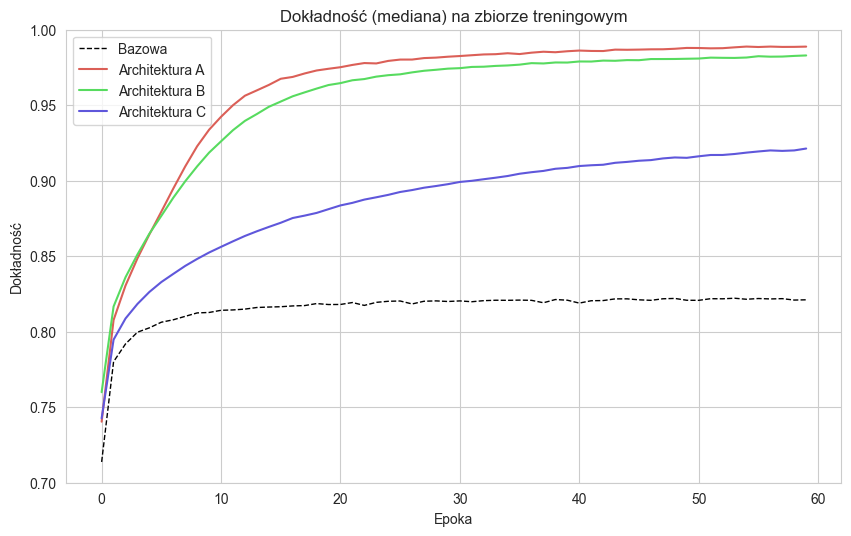

In [29]:
# plot on the same graph accuracy for all architectures, baseline-phcd-paper should be plotted as red dashed line
baseline = training_table[training_table["run_name"] == "baseline-phcd-paper"]
not_baseline = training_table[training_table["run_name"] != "baseline-phcd-paper"]

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.lineplot(data=baseline, x="epoch", y="accuracy", ax=ax, color="black", dashes=True)
sns.lineplot(data=not_baseline, x="epoch", y="accuracy", ax=ax, palette=sns.color_palette("hls", 3), hue="run_name")
ax.lines[0].set_linestyle("--")
ax.lines[0].set_zorder(100)
ax.lines[0].set_linewidth(1)

ax.set_title("Dokładność (mediana) na zbiorze treningowym")
ax.set_xlabel("Epoka")
ax.set_ylabel("Dokładność")
ax.set_ylim(0.7, 1.0)
ax.legend(architectures)
plt.show()
fig.savefig("train_acc.png")

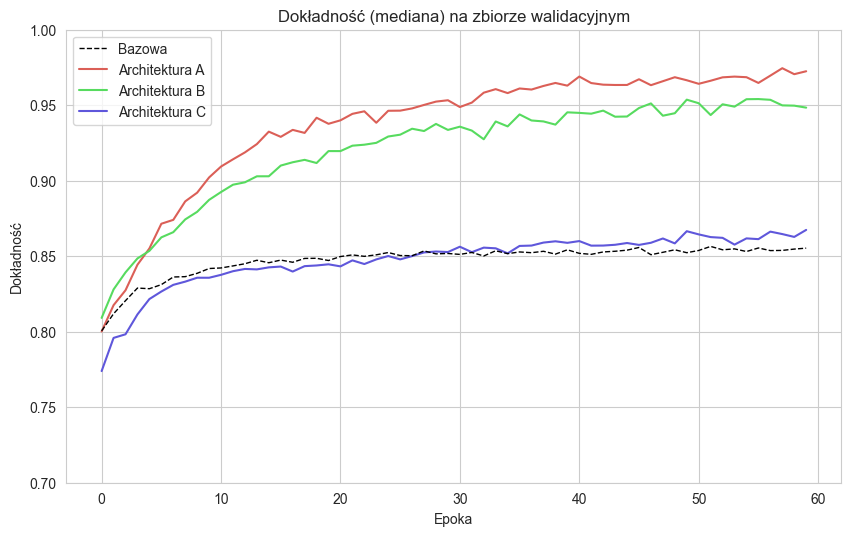

In [30]:
# plot on the same graph accuracy for all architectures, baseline-phcd-paper should be plotted as red dashed line
baseline = training_table[training_table["run_name"] == "baseline-phcd-paper"]
not_baseline = training_table[training_table["run_name"] != "baseline-phcd-paper"]

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.lineplot(data=baseline, x="epoch", y="val_accuracy", ax=ax, color="black", dashes=True)
sns.lineplot(data=not_baseline, x="epoch", y="val_accuracy", ax=ax, palette=sns.color_palette("hls", 3), hue="run_name")
ax.lines[0].set_linestyle("--")
ax.lines[0].set_zorder(100)
ax.lines[0].set_linewidth(1)

ax.set_title("Dokładność (mediana) na zbiorze walidacyjnym")
ax.set_xlabel("Epoka")
ax.set_ylabel("Dokładność")
# set y axis to range from 0.7 to 1.0
ax.set_ylim(0.7, 1.0)
ax.legend(architectures)
plt.show()
fig.savefig("val_acc.png")

c:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


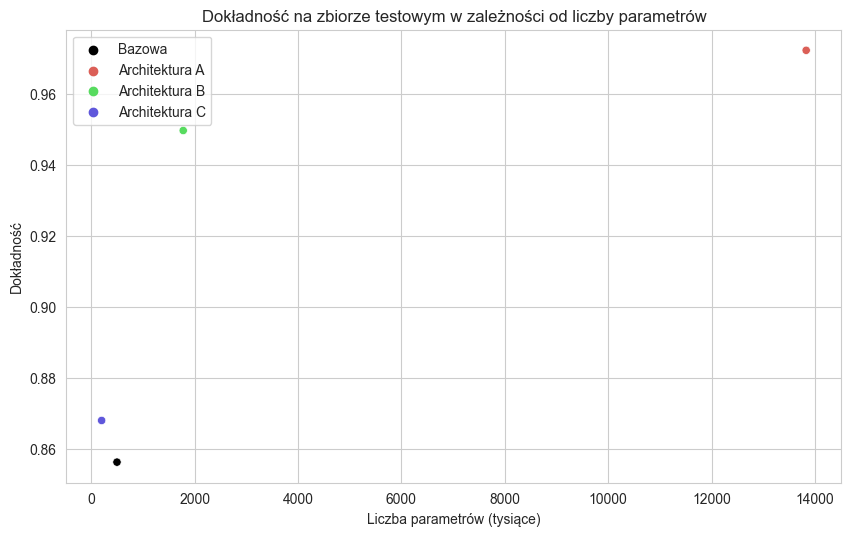

In [31]:
# palette sns.color_palette("hls", 3) with black added as first
palette = ["black"] + sns.color_palette("hls", 3)

# plot number of parameters vs test accuracy
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.scatterplot(data=results_table, x="number of parameters (thousands)", y="test acc", ax=ax, palette=palette, hue="label")
ax.set_title("Dokładność na zbiorze testowym w zależności od liczby parametrów")
ax.set_xlabel("Liczba parametrów (tysiące)")
ax.set_ylabel("Dokładność")
ax.legend()
plt.show()
fig.savefig("num_params_vs_test_acc.png")